## Morphological Feature Selection

In [1]:
# load third-party Python modules
import javabridge
import bioformats as bf
import skimage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import re
import os
import sys
import h5py
import json
from sklearn.manifold import TSNE

javabridge.start_vm(class_path=bf.JARS)

Function for loading viable cancer cells (`class = 2` output by the object detection model):

In [2]:
def load_viable_cells(platedir, wells, annot):
    imgdf = []
    for w in wells:
        df = pd.read_csv(os.path.join(platedir, w+'.csv'))
        imgdf.append(df[df['class'] == 2])
    imgdf = pd.concat(imgdf).reset_index(drop=True)
    labels = imgdf[['class', 'file']]
    imgdf = imgdf.drop(['class', 'file'], axis=1)
    labels['well'] = labels['file'].replace(regex=r'f[0-9].+', value='')
    labels['class'] = labels['class'].apply(lambda x: 'Viable' if x == 2 else 'Apoptotic')    
    labels = pd.merge(labels, annot, on='well')
    return imgdf, labels

Load plate annotation file:

In [3]:
# load plate annotation
annot_df = pd.read_csv('../data/AML_trainset/drugannot.txt',
                      sep='\t')

In [4]:
annot_df.head()

,well,Drug,conc,Culture
0,r04c13,Bafilomycin A1,0.04,Mono-culture
1,r04c14,Bafilomycin A1,0.04,Co-culture
2,r04c11,Bafilomycin A1,0.60,Mono-culture
3,r04c12,Bafilomycin A1,0.60,Co-culture
4,r04c09,Bafilomycin A1,9.00,Mono-culture


In [5]:
dmso = annot_df[annot_df.Drug == 'DMSO'].reset_index(drop=True)
dmso_wells = dmso['well'].unique()

Load viable cells from DMSO control wells:

In [6]:
#path = '/Volumes/gitlab/microscopy-notebooks/imgdata'
path = '../data/imgdata'
plate = '181109_Plate1'
ctrl_df, ctrl_annot = load_viable_cells(platedir=os.path.join(path, plate),
                            wells=dmso_wells, annot=dmso)

Remove features with near-zero variance, choose `thresh=1e-8`:

In [7]:
from bioimg.singlecell import select_features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=1e-8).fit(ctrl_df)

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:77: RuntimeWarning:

Degrees of freedom <= 0 for slice.



In [8]:
ctrl_df = select_features(df=ctrl_df, sel=sel)

Apply generalized logarithm-transform:

$$g(x) =  \log{\left(\frac{x+\sqrt{x^2+c^2}}{2}+ \varepsilon\right) }$$

with $c$, minimum value of each feature, and $\varepsilon$, a small number that prevents from taking log of zero.

In [9]:
def glog_transform(df, eps=1e-8):
    return df.apply(lambda x: np.log((x + np.sqrt(x**2 + x.min()**2))/2 + eps))

In [10]:
ctrl_df = glog_transform(df=ctrl_df)

In [11]:
from sklearn.preprocessing import StandardScaler
from bioimg.singlecell import scale_data, check_data

In [12]:
scaler = StandardScaler().fit(ctrl_df)
ctrl_scaled = scale_data(ctrl_df, scaler=scaler).reset_index(drop=True)

In [13]:
check_data(ctrl_scaled)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [14]:
# feature correlation
featcor = pd.DataFrame(np.corrcoef(ctrl_scaled.T),
                       index=ctrl_scaled.columns,
                       columns=ctrl_scaled.columns )

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



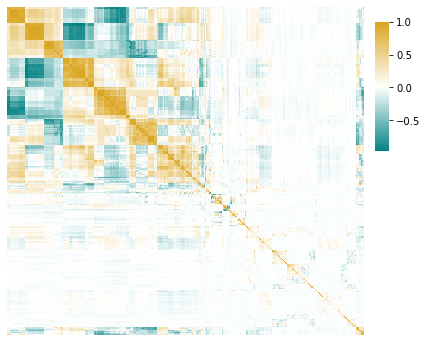

In [15]:
from bioimg.singlecell import plot_heatmap
plot_heatmap(featcor)

Check out features with few correlations:

In [16]:
featcor.columns[featcor.abs().sum(axis=1) < 30].values[:30]

array(['ch-Lysosomal-moments_normalized-3-0',
       'ch-Lysosomal-zernike-r15-20', 'ch-Lysosomal-zernike-r15-21',
       'ch-Lysosomal-zernike-r15-25', 'ch-Lysosomal-zernike-r15-26',
       'ch-Lysosomal-zernike-r15-30', 'ch-Lysosomal-zernike-r15-31',
       'ch-Lysosomal-zernike-r15-32', 'ch-Lysosomal-zernike-r15-34',
       'ch-Lysosomal-zernike-r15-36', 'ch-Lysosomal-zernike-r15-37',
       'ch-Lysosomal-zernike-r15-40', 'ch-Lysosomal-zernike-r15-41',
       'ch-Lysosomal-zernike-r15-42', 'ch-Lysosomal-zernike-r15-44',
       'ch-Lysosomal-zernike-r15-46', 'ch-Lysosomal-zernike-r15-47',
       'ch-Lysosomal-zernike-r18-30', 'ch-Lysosomal-zernike-r18-36',
       'ch-Lysosomal-zernike-r18-39', 'ch-Lysosomal-zernike-r18-42',
       'ch-Lysosomal-zernike-r18-43', 'ch-Lysosomal-zernike-r18-45',
       'ch-Lysosomal-zernike-r20-30', 'ch-Lysosomal-zernike-r20-37',
       'ch-Lysosomal-zernike-r20-41', 'ch-Lysosomal-zernike-r20-42',
       'ch-Lysosomal-zernike-r20-44', 'ch-Calcein-moments

## Feature selection based on replicate correlation
Load all wells from 2 AML replicate plates:

In [17]:
all_wells = annot_df['well'].values

In [18]:
plate = '181109_Plate1'
rep1_df, rep1_annot = load_viable_cells(platedir=os.path.join(path, plate), 
                                        wells=all_wells,
                                           annot=annot_df)

In [19]:
from bioimg.singlecell import preprocess_data
rep1_df = preprocess_data(df=rep1_df, sel=sel, glog=True)
# center and scale by control wells
scaler = StandardScaler().fit(rep1_df[rep1_annot['Drug']=='DMSO'])
rep1_scaled = scale_data(rep1_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [20]:
plate = '181109_Plate4'
rep2_df, rep2_annot = load_viable_cells(platedir=os.path.join(path, plate), 
                                        wells=all_wells,
                                       annot=annot_df)

In [21]:
rep2_df = preprocess_data(df=rep2_df, sel=sel, glog=True)
# center and scale by control wells
scaler = StandardScaler().fit(rep2_df[rep2_annot['Drug']=='DMSO'])
rep2_scaled = scale_data(rep2_df, scaler=scaler)

Number of columns with NaN/Inf values: 0
Number of rows with NaN/Inf values: 0


In [22]:
rep1_df.shape[1] == rep2_df.shape[1]

True

In [23]:
rep1_scaled.shape[1] == rep2_scaled.shape[1]

True

Compute mean well profiles for both replicate plates:

In [24]:
from bioimg.singlecell import aggregate_profiles
prof_rep1 = aggregate_profiles(rep1_scaled, rep1_annot)
prof_rep2 = aggregate_profiles(rep2_scaled, rep2_annot)

In [25]:
# Make sure that the same wells are present in both replicates
prof_rep1 = prof_rep1[np.isin(prof_rep1['well'], prof_rep2['well'])]
prof_rep2 = prof_rep2[np.isin(prof_rep2['well'], prof_rep1['well'])]

Simple function to compute well-wise correlation between every morphological feature measured in two replicate plates:

In [26]:
def get_repcor(prof1, prof2):
    repcor = prof1.sort_values(by='well').corrwith(prof2.sort_values(by='well'))
    return repcor

In [27]:
repcor = get_repcor(prof_rep1, prof_rep2)

In [28]:
sel_feats = repcor[repcor >= 0.6].index.values
X_subset = ctrl_scaled[sel_feats]

In [29]:
sel_feats = np.concatenate((sel_feats, np.array(['ch-Lysosomal-area'])))

In [30]:
# create a dictionary with various selected feature lists
featdict = dict()
featdict['repcor'] = sel_feats

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



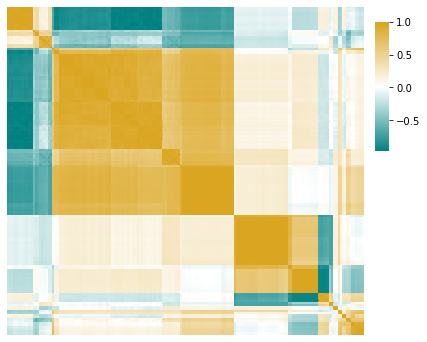

In [31]:
# feature correlation
featcor = pd.DataFrame(np.corrcoef(X_subset.T),
                       index=X_subset.columns,
                       columns=X_subset.columns )
plot_heatmap(featcor)

In [32]:
repcor[[f for f in sel_feats if 'Calcein' in f]]

ch-Calcein-convex_area                     0.613713
ch-Calcein-eccentricity                    0.639989
ch-Calcein-perimeter                       0.615869
ch-Calcein-major_axis_length               0.633801
ch-Calcein-inertia_tensor_eigvals-0        0.635867
ch-Calcein-moments_central-2-2             0.621064
ch-Calcein-moments_hu-1                    0.629524
ch-Calcein-weighted_moments_central-2-2    0.622067
dtype: float64

In [33]:
repcor[[f for f in sel_feats if 'Hoechst' in f]]

ch-Hoechst-mean_intensity                  0.646926
ch-Hoechst-weighted_moments_central-0-0    0.662787
ch-Hoechst-weighted_moments_central-2-0    0.617990
ch-Hoechst-contrast-0                      0.601667
ch-Hoechst-Contrast-d3-0                   0.601667
ch-Hoechst-Variance-d3-0                   0.622095
ch-Hoechst-SumAverage-d3-0                 0.612334
ch-Hoechst-SumVariance-d3-0                0.621293
ch-Hoechst-DifferenceVariance-d3-0         0.611352
ch-Hoechst-Variance-d3-1                   0.620734
ch-Hoechst-SumAverage-d3-1                 0.610858
ch-Hoechst-SumVariance-d3-1                0.620432
ch-Hoechst-DifferenceVariance-d3-1         0.602856
ch-Hoechst-Variance-d3-2                   0.622900
ch-Hoechst-SumAverage-d3-2                 0.611709
ch-Hoechst-SumVariance-d3-2                0.622528
ch-Hoechst-DifferenceVariance-d3-2         0.605591
ch-Hoechst-Variance-d3-3                   0.620748
ch-Hoechst-SumAverage-d3-3                 0.610829
ch-Hoechst-S

In [34]:
repcor[[f for f in sel_feats if 'Lysosomal' in f]]

ch-Lysosomal-mean_intensity                     0.697084
ch-Lysosomal-weighted_moments_central-0-0       0.616820
ch-Lysosomal-weighted_moments_hu-0              0.638066
ch-Lysosomal-weighted_moments_normalized-0-2    0.607331
ch-Lysosomal-weighted_moments_normalized-2-2    0.607432
                                                  ...   
ch-Lysosomal-InfoMeas1-d7-3                     0.673628
ch-Lysosomal-InfoMeas2-d7-3                     0.643019
ch-Lysosomal-zernike-r18-1                      0.612943
ch-Lysosomal-zernike-r20-1                      0.627124
ch-Lysosomal-area                               0.580705
Length: 110, dtype: float64

In [35]:
highcor = repcor[repcor > 0.6]

In [36]:
highcor_df = pd.DataFrame({'feature': highcor.index, 'repcor': highcor.values})

In [37]:
highcor_df['channel'] = np.NaN

In [38]:
highcor_df.loc[highcor_df['feature'].str.contains('Lysosomal'),'channel'] = 'Lysosomal'
highcor_df.loc[highcor_df['feature'].str.contains('Hoechst'),'channel'] = 'Hoechst'
highcor_df.loc[highcor_df['feature'].str.contains('Calcein'),'channel'] = 'Calcein'

In [39]:
colors = ["medium green", "denim blue", "magenta"]
pal = sn.xkcd_palette(colors)

In [40]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [41]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 9}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


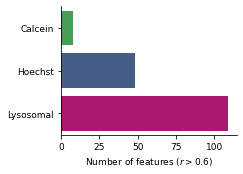

In [42]:
plt.figure(figsize=cm2inch(8,6))
sn.barplot(data=highcor_df.groupby('channel', 
                                   as_index=False).agg('count'), 
           y='channel', x='feature', palette=pal)
plt.xlabel('Number of features ($r>0.6$)')
plt.ylabel('')
sn.set(style='white')
sn.despine()
#plt.savefig('../figures/repcor-features.pdf', bbox_inches='tight')

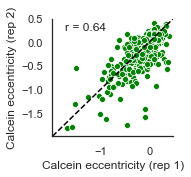

In [43]:
fig, ax = plt.subplots(figsize=cm2inch(5.5,5.5))
plt.plot([-2, 0.5], [-2, 0.5], linewidth=1.5, linestyle='--', color='black')
sn.scatterplot(x='ch-Calcein-eccentricity_x', y='ch-Calcein-eccentricity_y',
               data=pd.merge(prof_rep1[['well', 'ch-Calcein-eccentricity']],
          prof_rep2[['well', 'ch-Calcein-eccentricity']], on='well'), ax=ax,
              facecolor='green')

sn.despine()
ax.annotate("r = {:.2f}".format(repcor['ch-Calcein-eccentricity']),
                xy=(.1, .9), xycoords=ax.transAxes)
ax.set_xlim((-2,0.5))
ax.set_ylim((-2,0.5))

plt.xlabel('Calcein eccentricity (rep 1)')
plt.ylabel('Calcein eccentricity (rep 2)')
xticks = ax.xaxis.get_major_ticks() 
xticks[0].label1.set_visible(False)
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)
sn.set_palette(sn.xkcd_palette(['medium green']))
sn.set(style='white')
#fig.savefig('../figures/eccentricity-repcor.pdf', bbox_inches='tight')

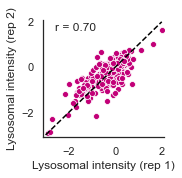

In [44]:
fig, ax = plt.subplots(figsize=cm2inch(5.5,5.5))
plt.plot([-3, 2], [-3, 2], linewidth=1.5, linestyle='--', color='black')
sn.scatterplot(x='ch-Lysosomal-mean_intensity_x', y='ch-Lysosomal-mean_intensity_y',
               data=pd.merge(prof_rep1[['well', 'ch-Lysosomal-mean_intensity']],
                             prof_rep2[['well', 'ch-Lysosomal-mean_intensity']], on='well'), ax=ax,
              facecolor='#c20078')
sn.despine()
ax.annotate("r = {:.2f}".format(repcor['ch-Lysosomal-mean_intensity']),
            xy=(.1, .9), xycoords=ax.transAxes)
ax.set_xlim((-3.1,2.1))
ax.set_ylim((-3.1,2.1))
plt.xlabel('Lysosomal intensity (rep 1)')
plt.ylabel('Lysosomal intensity (rep 2)')
xticks = ax.xaxis.get_major_ticks() 
xticks[0].label1.set_visible(False)
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)
sn.set(style='white')
#fig.savefig('../figures/lysos-intensity-repcor.pdf', bbox_inches='tight')

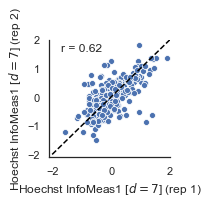

In [46]:
fig, ax = plt.subplots(figsize=cm2inch(5.5,5.5))
plt.plot([-2, 2], [-2, 2], linewidth=1.5, linestyle='--', color='black')
sn.scatterplot(x='ch-Hoechst-InfoMeas1-d7-3_x', y='ch-Hoechst-InfoMeas1-d7-3_y',
               data=pd.merge(prof_rep1[['well', 'ch-Hoechst-InfoMeas1-d7-3']],
                             prof_rep2[['well', 'ch-Hoechst-InfoMeas1-d7-3']], on='well'), ax=ax)
sn.despine()
ax.annotate("r = {:.2f}".format(repcor['ch-Hoechst-InfoMeas1-d7-3']),
            xy=(.1, .9), xycoords=ax.transAxes)
ax.set_xlim((-2.1,2))
ax.set_ylim((-2.1,2))
plt.xlabel('Hoechst InfoMeas1 [$d=7$] (rep 1)')
plt.ylabel('Hoechst InfoMeas1 [$d=7$] (rep 2)')
xticks = ax.xaxis.get_major_ticks() 
xticks[0].label1.set_visible(False)
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)
sn.set(style='white')
#fig.savefig('../figures/Hoechst-infomeas-repcor.pdf', bbox_inches='tight')

In [47]:
prof_rep1 = prof_rep1[sel_feats]
prof_rep2 = prof_rep2[sel_feats]

## Feature Selection Based on Residuals
Select initial feature set:

In [48]:
from bioimg.singlecell import select_residcor
sel_feats = select_residcor(prof1=prof_rep1, prof2=prof_rep2,
                            sel = ['ch-Calcein-eccentricity', 
                                   'ch-Hoechst-mean_intensity',
                                   'ch-Lysosomal-mean_intensity',
                                   'ch-Lysosomal-area'])

In [49]:
print("Number of selected features: %d" % len(sel_feats))

Number of selected features: 44


In [50]:
featdict['residcor'] = sel_feats

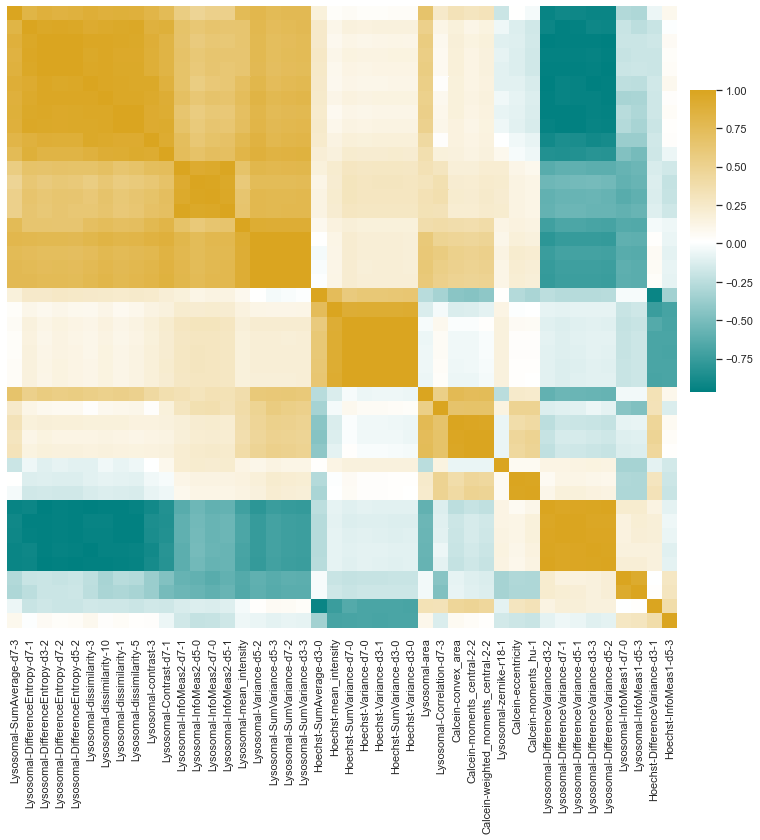

In [51]:
X_subset = ctrl_scaled[sel_feats]
featnames = [f.replace('ch-', '') for f in X_subset.columns]
# feature correlation
featcor = pd.DataFrame(np.corrcoef(X_subset.T),
                       index=featnames,
                       columns=featnames )
plot_heatmap(featcor, xticklabels=True, size=(12,14))
plt.show()
#plt.savefig('../figures/residcor-featsel.pdf', bbox_inches='tight')

## Further Feature Selection

In [52]:
y=np.copy(ctrl_annot['Culture'].values)
y[y=='Mono-culture'] = 0
y[y=='Co-culture'] = 1
y = y.astype(int)

Univariate feature selection method:

In [53]:
from sklearn.feature_selection import SelectKBest, SelectFdr, f_classif
from bioimg.singlecell import select_features
sel = SelectKBest(f_classif, k=20).fit(X=X_subset, y=y)
X_kbest = select_features(df=X_subset, sel=sel)

In [54]:
X_kbest.columns

Index(['ch-Lysosomal-mean_intensity', 'ch-Lysosomal-SumAverage-d7-3',
       'ch-Lysosomal-DifferenceVariance-d3-2', 'ch-Lysosomal-contrast-3',
       'ch-Lysosomal-DifferenceVariance-d7-1', 'ch-Lysosomal-dissimilarity-1',
       'ch-Lysosomal-dissimilarity-3', 'ch-Lysosomal-DifferenceVariance-d5-1',
       'ch-Lysosomal-dissimilarity-5', 'ch-Lysosomal-DifferenceEntropy-d3-2',
       'ch-Lysosomal-dissimilarity-10', 'ch-Lysosomal-DifferenceEntropy-d7-2',
       'ch-Lysosomal-DifferenceVariance-d3-3',
       'ch-Lysosomal-DifferenceEntropy-d5-2', 'ch-Lysosomal-SumVariance-d7-2',
       'ch-Lysosomal-Variance-d5-2', 'ch-Lysosomal-SumVariance-d3-3',
       'ch-Lysosomal-DifferenceEntropy-d7-1',
       'ch-Lysosomal-DifferenceVariance-d5-2', 'ch-Lysosomal-Contrast-d7-1'],
      dtype='object')

In [55]:
sel = SelectFdr(f_classif, alpha=0.01).fit(X=X_subset, y=y)
X_fdr = select_features(df=X_subset, sel=sel)

In [56]:
X_fdr.shape

(4632, 43)

In [57]:
X_subset.columns[:20]

Index(['ch-Calcein-eccentricity', 'ch-Hoechst-mean_intensity',
       'ch-Lysosomal-mean_intensity', 'ch-Lysosomal-area',
       'ch-Lysosomal-SumAverage-d7-3', 'ch-Lysosomal-DifferenceVariance-d3-2',
       'ch-Lysosomal-InfoMeas2-d5-0', 'ch-Lysosomal-contrast-3',
       'ch-Hoechst-Variance-d7-0', 'ch-Hoechst-SumAverage-d3-0',
       'ch-Hoechst-DifferenceVariance-d3-1', 'ch-Calcein-moments_central-2-2',
       'ch-Hoechst-InfoMeas1-d5-3', 'ch-Lysosomal-Correlation-d7-3',
       'ch-Calcein-weighted_moments_central-2-2', 'ch-Calcein-moments_hu-1',
       'ch-Lysosomal-InfoMeas2-d7-1', 'ch-Lysosomal-InfoMeas2-d7-0',
       'ch-Lysosomal-InfoMeas2-d5-1', 'ch-Hoechst-SumVariance-d7-0'],
      dtype='object')

In [58]:
from bioimg.singlecell import recursive_elim

In [59]:
rfe = recursive_elim(df=X_subset, y=y, n_feat=9, elim_step=1)

In [60]:
X_rfe = select_features(df=X_subset, sel=rfe)

## Visualize Single Cells Based on Selected Features

In [61]:
X_tsne = TSNE(n_components=2, random_state=21, perplexity=50).fit_transform(X_subset)

In [62]:
X_df = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']), ctrl_annot], axis=1)

In [63]:
feat_subset =X_rfe.columns.values
Xfeat = ctrl_scaled.loc[:,feat_subset]
X_df = pd.concat([X_df, Xfeat], axis=1)

(<Figure size 648x576 with 1 Axes>,
 <AxesSubplot:title={'center':'DMSO control wells'}, xlabel='TSNE 1', ylabel='TSNE 2'>)

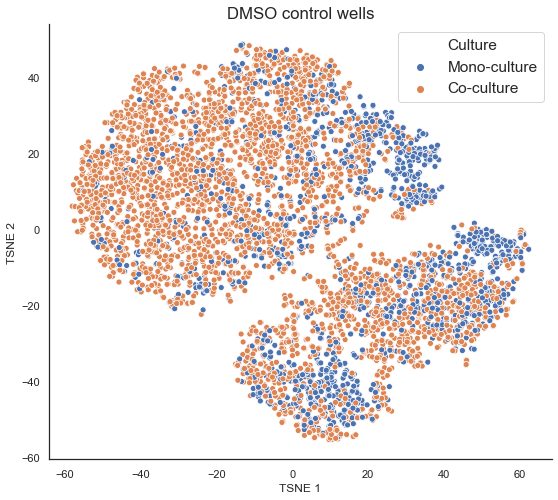

In [64]:
from bioimg.singlecell import plot_dimred
plot_dimred(X_df, 
            hue='Culture',
            title='DMSO control wells')

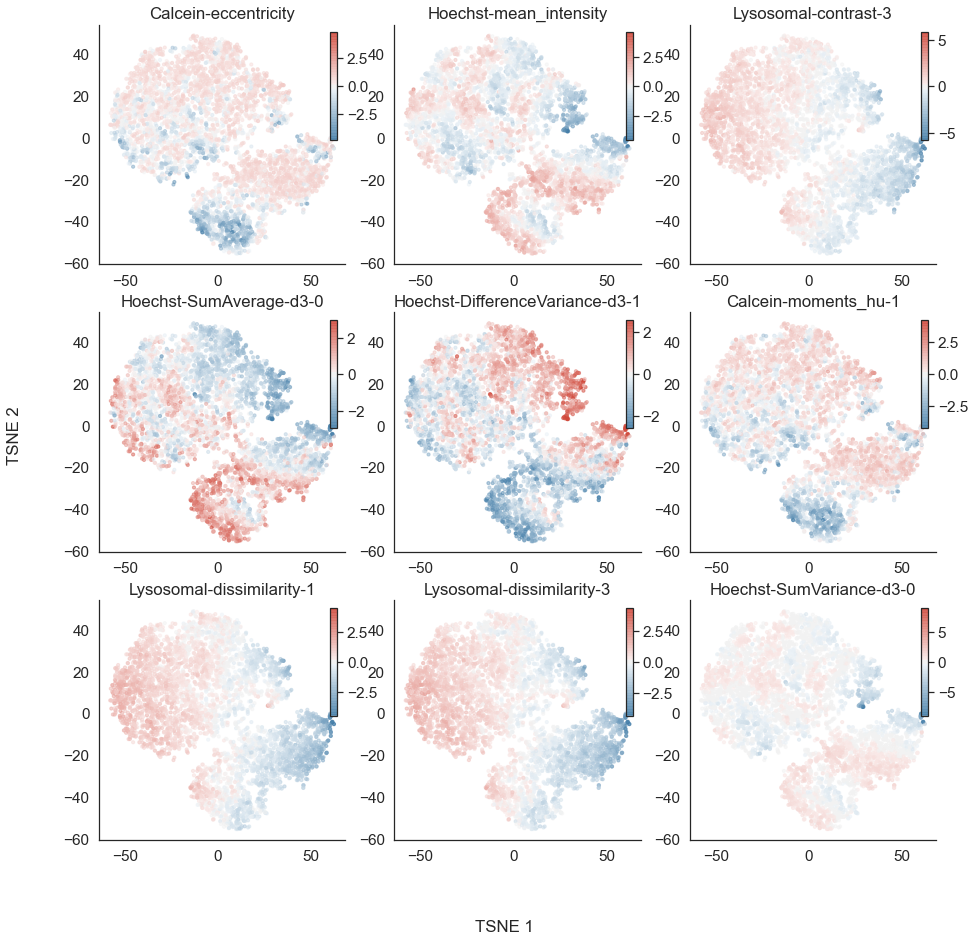

In [65]:
from bioimg.singlecell import facet_dimred
facet_dimred(X_df, feat_subset=feat_subset,
            nrows=3, ncols=3)

In [66]:
colsub = ['Culture'] + feat_subset.tolist()
X_long = pd.melt(X_df[colsub], 
                 id_vars=['Culture'], 
                 value_vars=feat_subset,
                 var_name='feature', 
                 value_name='val')

<Figure size 1008x720 with 0 Axes>

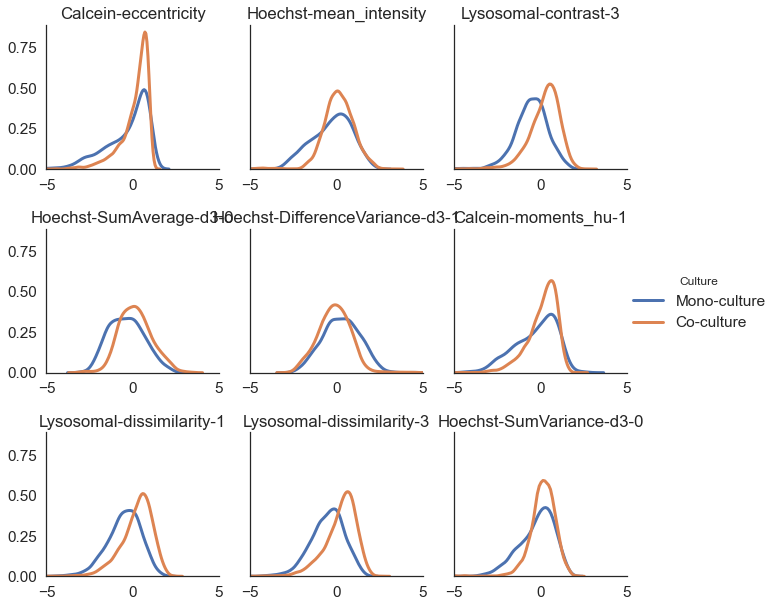

In [67]:
from bioimg.singlecell import facet_density
facet_density(X_long, feat_column='feature',
             ncols=3, hue='Culture',
             sharey=True, size=(14,10), xlim=(-5,5))

## Constructing Non-Redundant Set of Features

In [68]:
both = pd.concat([rep1_scaled, rep2_scaled], axis=0)
candidate_feats = both[sel_feats]

In [69]:
from bioimg.singlecell import select_uncorrelated
sel_feats = select_uncorrelated(df=candidate_feats, 
                                sel=['ch-Calcein-eccentricity', 
                                     'ch-Hoechst-mean_intensity',
                                     'ch-Lysosomal-mean_intensity',
                                     'ch-Lysosomal-area'])

In [70]:
featdict['uncorr'] = sel_feats

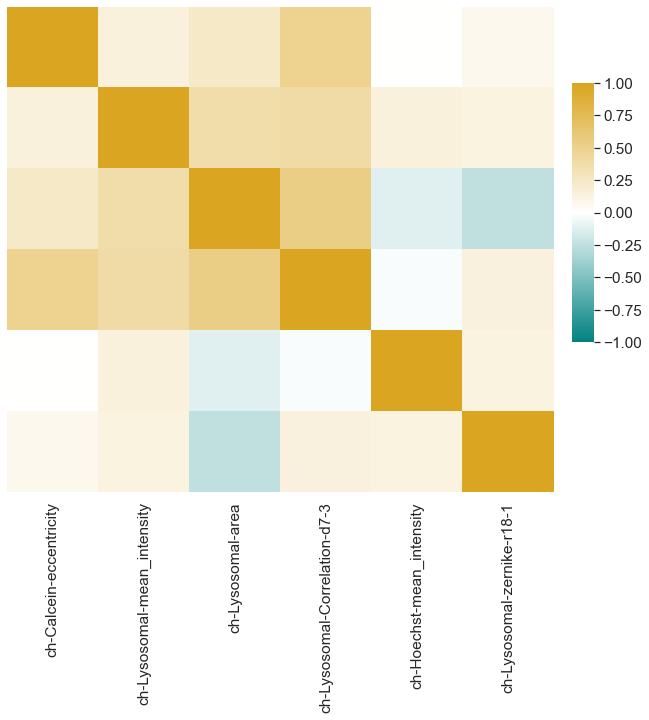

In [71]:
X_subset = ctrl_scaled[sel_feats]
# feature correlation
featcor = pd.DataFrame(np.corrcoef(X_subset.T),
                       index=X_subset.columns,
                       columns=X_subset.columns )
plot_heatmap(featcor, vmax=1, vmin=-1,
             xticklabels=True, size=(10,12))

In [72]:
print("Number of non-redundant features: %d" % len(sel_feats))

Number of non-redundant features: 6


In [73]:
rfe = recursive_elim(df=X_subset, y=y, n_feat=6, elim_step=1)
X_rfe = select_features(df=X_subset, sel=rfe)

In [74]:
X_tsne = TSNE(n_components=2, random_state=21, perplexity=50).fit_transform(X_subset)

In [75]:
X_df = pd.concat([pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2']), ctrl_annot], axis=1)

In [76]:
feat_subset = X_rfe.columns.values
Xfeat = ctrl_scaled.loc[:,feat_subset]
X_df = pd.concat([X_df, Xfeat], axis=1)

(<Figure size 648x576 with 1 Axes>,
 <AxesSubplot:title={'center':'DMSO control wells'}, xlabel='TSNE 1', ylabel='TSNE 2'>)

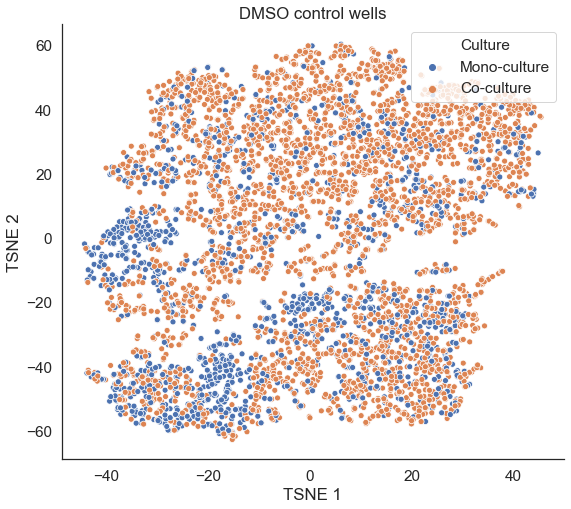

In [77]:
from bioimg.singlecell import plot_dimred
plot_dimred(X_df, 
            hue='Culture',
            title='DMSO control wells')

In [78]:
from bioimg.singlecell import facet_dimred
'''facet_dimred(X_df, feat_subset=feat_subset,
            nrows=2, ncols=3)'''

'facet_dimred(X_df, feat_subset=feat_subset,\n            nrows=2, ncols=3)'

In [79]:
colsub = ['Culture'] + feat_subset.tolist()
X_long = pd.melt(X_df[colsub], 
                 id_vars=['Culture'], 
                 value_vars=feat_subset,
                 var_name='feature', 
                 value_name='val')

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

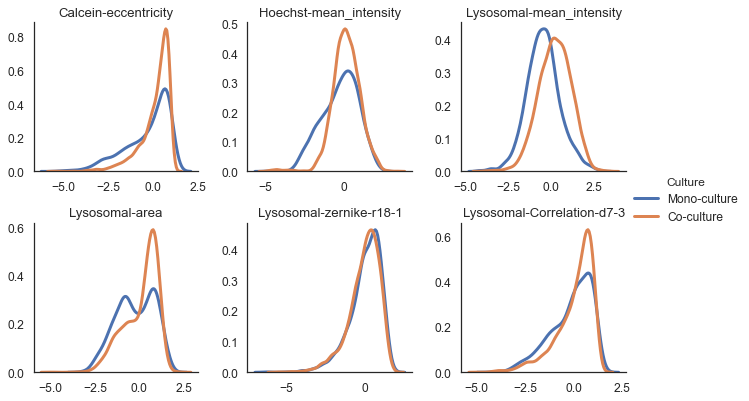

In [80]:
from bioimg.singlecell import facet_density
sn.set(font_scale=1.1)
sn.set_style('white')
sn.despine()
facet_density(X_long, feat_column='feature',
             ncols=3,  hue='Culture', sharey=False)

In [81]:
featdict = {k : v if type(v)==list else v.tolist() for k,v in featdict.items()}

In [82]:
# write selected features to a file
'''with open('featselect.json', 'w') as fp:
    json.dump(featdict, fp)'''

"with open('featselect.json', 'w') as fp:\n    json.dump(featdict, fp)"

In [83]:
featdict.keys()

dict_keys(['repcor', 'residcor', 'uncorr'])